# Deep Learning – Assignment 1: Single-Word Audio Classification 

## Library

In [13]:
!nvidia-smi

Mon Apr 14 14:04:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0             19W /   75W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [15]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Extract Audio

In [26]:
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        self.label_map = {}

        for idx, label in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                self.label_map[idx] = label
                for file in os.listdir(label_path):
                    if file.endswith(".wav"):
                        self.samples.append(os.path.join(label_path, file))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        feature = np.mean(mfcc.T, axis=0)
        return torch.tensor(feature, dtype=torch.float32), label

In [27]:
train_dataset = AudioDataset("data/Training")
test_dataset = AudioDataset("data/Testing")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training


In [28]:
class AudioFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [29]:
input_size = 13
num_classes = len(train_dataset.label_map)
model = AudioFNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# from torchsummary import summary

# summary(model, input_size=(1, 28, 28))

In [ ]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset) # type: ignore

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset) # type: ignore

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs=30, device=device)

## Result


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

Training Progress:   3%|▎         | 1/30 [00:02<01:04,  2.21s/it]

Epoch 1/30: Train loss: 3.6010, Train accuracy: 0.2917, Val loss: 1.9666, Val accuracy: 0.3000, Time: 2.21s


Training Progress:   7%|▋         | 2/30 [00:04<01:01,  2.18s/it]

Epoch 2/30: Train loss: 1.2648, Train accuracy: 0.3708, Val loss: 1.0356, Val accuracy: 0.5167, Time: 2.15s


Training Progress:  10%|█         | 3/30 [00:06<00:58,  2.17s/it]

Epoch 3/30: Train loss: 0.9399, Train accuracy: 0.5250, Val loss: 0.9499, Val accuracy: 0.5500, Time: 2.16s


Training Progress:  13%|█▎        | 4/30 [00:08<00:56,  2.16s/it]

Epoch 4/30: Train loss: 0.8705, Train accuracy: 0.5750, Val loss: 1.0357, Val accuracy: 0.5167, Time: 2.14s


Training Progress:  17%|█▋        | 5/30 [00:10<00:54,  2.16s/it]

Epoch 5/30: Train loss: 0.8221, Train accuracy: 0.5917, Val loss: 0.8782, Val accuracy: 0.5667, Time: 2.17s


Training Progress:  20%|██        | 6/30 [00:12<00:51,  2.16s/it]

Epoch 6/30: Train loss: 0.7849, Train accuracy: 0.6250, Val loss: 0.9045, Val accuracy: 0.5000, Time: 2.14s


Training Progress:  23%|██▎       | 7/30 [00:15<00:49,  2.16s/it]

Epoch 7/30: Train loss: 0.7100, Train accuracy: 0.6583, Val loss: 0.9118, Val accuracy: 0.5833, Time: 2.17s


Training Progress:  27%|██▋       | 8/30 [00:17<00:47,  2.16s/it]

Epoch 8/30: Train loss: 0.7440, Train accuracy: 0.6458, Val loss: 0.9254, Val accuracy: 0.5167, Time: 2.14s


Training Progress:  30%|███       | 9/30 [00:19<00:45,  2.16s/it]

Epoch 9/30: Train loss: 0.7004, Train accuracy: 0.6583, Val loss: 0.9797, Val accuracy: 0.5500, Time: 2.16s


Training Progress:  33%|███▎      | 10/30 [00:21<00:43,  2.15s/it]

Epoch 10/30: Train loss: 0.6088, Train accuracy: 0.7167, Val loss: 0.8633, Val accuracy: 0.6333, Time: 2.13s


Training Progress:  37%|███▋      | 11/30 [00:23<00:40,  2.15s/it]

Epoch 11/30: Train loss: 0.5838, Train accuracy: 0.7500, Val loss: 0.9809, Val accuracy: 0.5333, Time: 2.16s


Training Progress:  40%|████      | 12/30 [00:26<00:39,  2.18s/it]

Epoch 12/30: Train loss: 0.5816, Train accuracy: 0.7375, Val loss: 1.0609, Val accuracy: 0.5167, Time: 2.23s


Training Progress:  43%|████▎     | 13/30 [00:28<00:36,  2.17s/it]

Epoch 13/30: Train loss: 0.6316, Train accuracy: 0.7375, Val loss: 0.9101, Val accuracy: 0.5500, Time: 2.14s


Training Progress:  47%|████▋     | 14/30 [00:30<00:34,  2.17s/it]

Epoch 14/30: Train loss: 0.6030, Train accuracy: 0.7375, Val loss: 0.9919, Val accuracy: 0.4833, Time: 2.17s


Training Progress:  50%|█████     | 15/30 [00:32<00:32,  2.17s/it]

Epoch 15/30: Train loss: 0.6115, Train accuracy: 0.7333, Val loss: 0.9081, Val accuracy: 0.5833, Time: 2.16s


Training Progress:  53%|█████▎    | 16/30 [00:34<00:30,  2.15s/it]

Epoch 16/30: Train loss: 0.5451, Train accuracy: 0.7583, Val loss: 0.8577, Val accuracy: 0.5667, Time: 2.11s


Training Progress:  57%|█████▋    | 17/30 [00:36<00:28,  2.16s/it]

Epoch 17/30: Train loss: 0.5723, Train accuracy: 0.7417, Val loss: 0.8921, Val accuracy: 0.6000, Time: 2.17s


Training Progress:  60%|██████    | 18/30 [00:38<00:25,  2.15s/it]

Epoch 18/30: Train loss: 0.6280, Train accuracy: 0.7333, Val loss: 0.9457, Val accuracy: 0.5833, Time: 2.12s


Training Progress:  63%|██████▎   | 19/30 [00:41<00:23,  2.15s/it]

Epoch 19/30: Train loss: 0.5036, Train accuracy: 0.8000, Val loss: 0.9977, Val accuracy: 0.6333, Time: 2.15s


Training Progress:  67%|██████▋   | 20/30 [00:43<00:21,  2.15s/it]

Epoch 20/30: Train loss: 0.4882, Train accuracy: 0.8250, Val loss: 1.0596, Val accuracy: 0.6667, Time: 2.14s


Training Progress:  70%|███████   | 21/30 [00:45<00:19,  2.18s/it]

Epoch 21/30: Train loss: 0.5033, Train accuracy: 0.8042, Val loss: 1.0581, Val accuracy: 0.6000, Time: 2.24s


Training Progress:  73%|███████▎  | 22/30 [00:47<00:17,  2.15s/it]

Epoch 22/30: Train loss: 0.4985, Train accuracy: 0.7875, Val loss: 1.1907, Val accuracy: 0.5833, Time: 2.10s


Training Progress:  77%|███████▋  | 23/30 [00:49<00:15,  2.17s/it]

Epoch 23/30: Train loss: 0.4865, Train accuracy: 0.7875, Val loss: 1.2842, Val accuracy: 0.6000, Time: 2.19s


Training Progress:  80%|████████  | 24/30 [00:51<00:12,  2.16s/it]

Epoch 24/30: Train loss: 0.4783, Train accuracy: 0.7917, Val loss: 1.1170, Val accuracy: 0.6000, Time: 2.15s


Training Progress:  83%|████████▎ | 25/30 [00:54<00:10,  2.16s/it]

Epoch 25/30: Train loss: 0.5130, Train accuracy: 0.8042, Val loss: 1.0983, Val accuracy: 0.5667, Time: 2.16s


Training Progress:  87%|████████▋ | 26/30 [00:56<00:08,  2.17s/it]

Epoch 26/30: Train loss: 0.4776, Train accuracy: 0.7708, Val loss: 1.0305, Val accuracy: 0.5667, Time: 2.18s


Training Progress:  90%|█████████ | 27/30 [00:58<00:06,  2.16s/it]

Epoch 27/30: Train loss: 0.4838, Train accuracy: 0.7917, Val loss: 1.0228, Val accuracy: 0.5667, Time: 2.12s


Training Progress:  93%|█████████▎| 28/30 [01:00<00:04,  2.16s/it]

Epoch 28/30: Train loss: 0.4978, Train accuracy: 0.7750, Val loss: 1.0548, Val accuracy: 0.5833, Time: 2.15s


Training Progress:  97%|█████████▋| 29/30 [01:02<00:02,  2.13s/it]

Epoch 29/30: Train loss: 0.5079, Train accuracy: 0.7792, Val loss: 1.0581, Val accuracy: 0.5333, Time: 2.07s


Training Progress: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


Epoch 30/30: Train loss: 0.5258, Train accuracy: 0.7875, Val loss: 1.0820, Val accuracy: 0.4833, Time: 2.11s


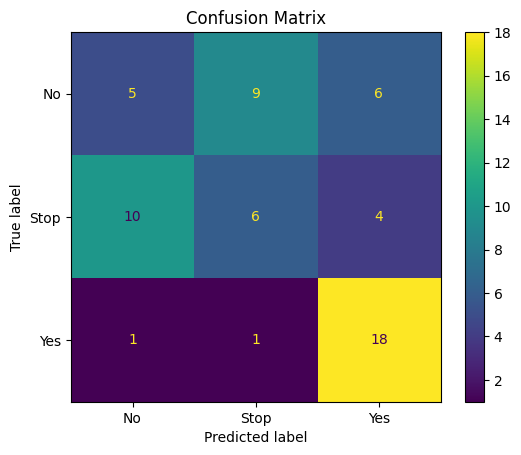

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[train_dataset.label_map[i] for i in range(num_classes)]).plot()
plt.title("Confusion Matrix")
plt.show()

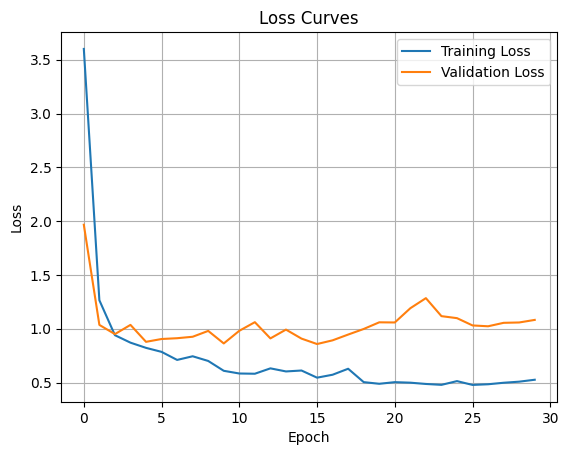

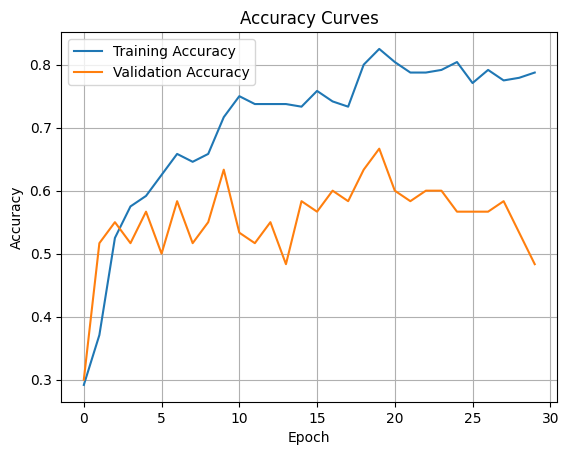

In [33]:
plt.figure()
plt.plot(history['train_loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history['train_accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()